# Plots zur Datenvisualisierung

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Load data
bike_data = pd.read_csv("../data/full_bike_data_cleaned.csv", low_memory=False)
bike_data['timestamp'] = pd.to_datetime(bike_data['timestamp'], errors='coerce')
bike_data['timestamp'] = bike_data['timestamp'].dt.tz_convert('Europe/Berlin') # konvertieren um Zeitumstellungsprobleme zu lösen


In [45]:
# daten für ausgewählte counter fuktern
selected_counter = ["Wiwilibrücke"] #oder FR3 Eschholzstraße
bike_data_selected = bike_data[bike_data['counter_site'].isin(selected_counter)]
bike_data_selected.head()

,city,counter_site,longitude,latitude,count,timestamp
0,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,51,2013-01-01 00:00:00+01:00
1,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,117,2013-01-01 01:00:00+01:00
2,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,131,2013-01-01 02:00:00+01:00
3,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,145,2013-01-01 03:00:00+01:00
4,Stadt Freiburg,Wiwilibrücke,7.840753,47.995213,76,2013-01-01 04:00:00+01:00


C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\1870754025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\1870754025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['weekday'] = bike_data_selected['timestamp'].dt.day_name()


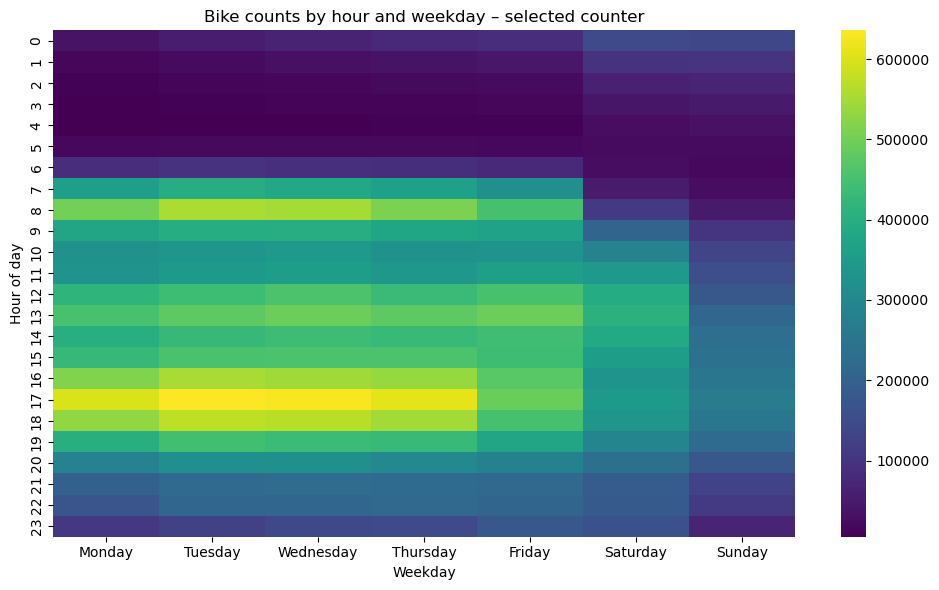

In [46]:
# Heatmap plot with axes time and day of week for selected counter

# Extract hour and weekday
bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
bike_data_selected['weekday'] = bike_data_selected['timestamp'].dt.day_name()

# Aggregate counts
heat_df = bike_data_selected.pivot_table(
    index='hour',
    columns='weekday',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Order weekdays Monday–Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_df = heat_df.reindex(columns=weekday_order)

plt.figure(figsize=(10, 6))
sns.heatmap(heat_df, cmap='viridis')
plt.title('Bike counts by hour and weekday – selected counter')
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.tight_layout()
plt.show()

C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\336115185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
C:\Users\kraus\AppData\Local\Temp\ipykernel_2560\336115185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['day_of_year'] = bike_data_selected['timestamp'].dt.dayofyear


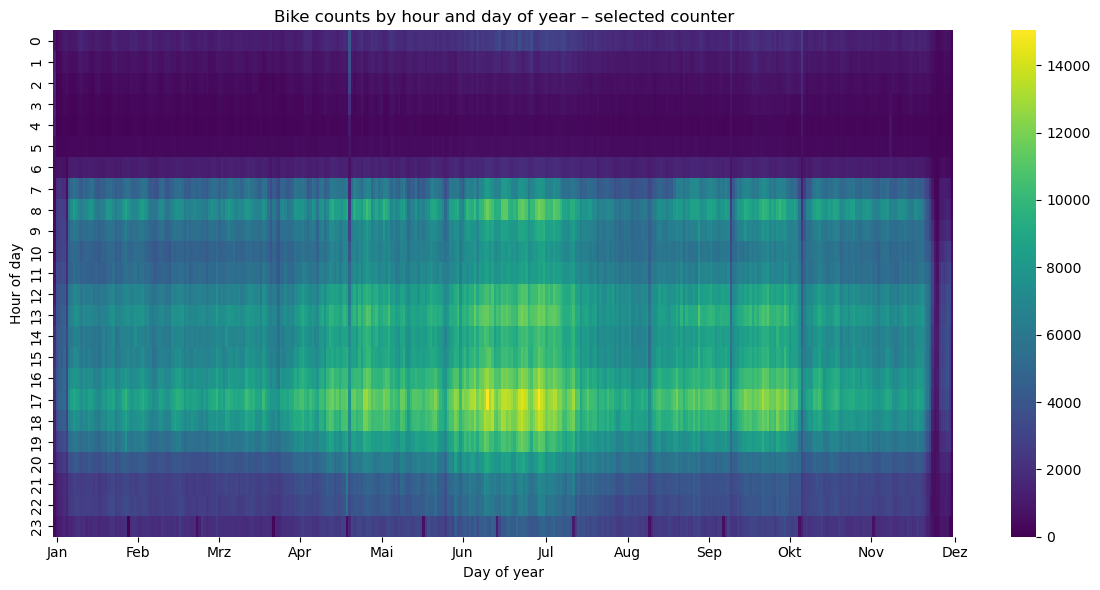

In [47]:
# Heatmap plot with axes time and day of year for selected counter

# Extract hour and day of year
bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
bike_data_selected['day_of_year'] = bike_data_selected['timestamp'].dt.dayofyear

# Aggregate counts
heat_df = bike_data_selected.pivot_table(
    index='hour',
    columns='day_of_year',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Spalten nach Tag-im-Jahr sortieren (x-Achse)
heat_df = heat_df.reindex(sorted(heat_df.columns), axis=1)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heat_df, cmap='viridis')
plt.title('Bike counts by hour and day of year – selected counter')
plt.xlabel('Day of year')
plt.ylabel('Hour of day')

# Tick-Positionen und Labels (Monate)
if not heat_df.empty:
    min_day, max_day = heat_df.columns.min(), heat_df.columns.max()
    ticks = np.linspace(min_day, max_day, 12, dtype=int)
    base_year = int(bike_data_selected['timestamp'].dt.year.mode().iloc[0])
    labels = pd.to_datetime(ticks - 1, unit='D', origin=f'{base_year}-01-01').strftime('%b')
    ax.set_xticks(ticks + 0.5)  # center ticks
    ax.set_xticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()